Notebook, Module 1 & 2 data science project, CAS Applied Data Science, Petra Müller, University of Bern. 

# Can the ”1:12 - for fair wages” Popular Initiative vote result be explained by income and income inequality?

### Primary Objectives
The main goal of this data science project was to examine the relationship between the acceptance of the Popular Initiative "1:12 - for fair wages" in Switzerland in the year 2013 and income as well as income inequality on a communal level. The following research questions were stated:

- Is there a relationship between income inequality (Gini-coefficient) and acceptance of the ”1:12 - for fair wages” Popular Initiative?
- Is there a relationship between wealth (income) and acceptance of the ”1:12 -for fair wages” Popular Initiative?

Thus the analysis objective is to uncover possible correlations between income, income inequality and the vote result as well as to examine possible correlations more detailed to maybe uncover other factors (moderators) that might shape the relationship between variables. 

### Secondary objectives

Out of personal curiosity and interest the secondary objective of this project is to visualise voting data as well as income data by use of geographical maps, that is to combine geospatial data (polygons) and vote/tax data to create informative geographical map plots. 

## 1. Reading data files

In [55]:
# importing necessary libraries:
import geopandas as gpd
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib
import numpy as np
import pandas_bokeh
import bokeh
from bokeh.models import LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar, ColumnDataSource, HoverTool, WheelZoomTool, Slope, LogColorMapper, LogTicker
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn

The geopandas library is used to read geospatial data. More information: http://geopandas.org/

- 'g1g14vz.shp' is a so called shapefile (https://en.wikipedia.org/wiki/Shapefile) and contains geospatial data on swiss communes in 2014. 
- 'analysis_dataset.csv' contains preprocessed vote data and tax data as described in Pmueller_conceptual_design_report.pdf.

In [2]:
geodata = gpd.read_file("data/geodata/shp/g1g14vz.shp")
analysis = pd.read_csv("data/analysis_dataset.csv")

Checking the content of the datasets:

An explanation of the variables can be found in geodata_variables.txt (for geographical data) and analysis_dataset_variables.txt (for the analysis data set) in the Metadata folder. 

In [3]:
print(geodata.info())
print(analysis.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
GMDNR       2356 non-null int64
GMDNAME     2356 non-null object
BZNR        2356 non-null int64
KTNR        2356 non-null int64
GRNR        2356 non-null int64
AREA_HA     2356 non-null int64
X_MIN       2356 non-null int64
X_MAX       2356 non-null int64
Y_MIN       2356 non-null int64
Y_MAX       2356 non-null int64
X_CNTR      2356 non-null int64
Y_CNTR      2356 non-null int64
Z_MIN       2356 non-null int64
Z_MAX       2356 non-null int64
Z_AVG       2356 non-null int64
Z_MED       2356 non-null int64
geometry    2356 non-null object
dtypes: int64(15), object(2)
memory usage: 313.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 12 columns):
commune          2343 non-null object
vote_yes         2343 non-null int64
vote_no          2343 non-null int64
turnout_perc     2343 non-null float64
canton           2343 n

In [4]:
import math
# i convert the 'percent_yes' to a more human readable percentage format
analysis["percent_yes"]= analysis["percent_yes"]*100
# also some bfsnr's are missing, so we can not convert to int but this workaround helps
analysis["bfsnr"] = np.nan_to_num(analysis["bfsnr"])
analysis=analysis.astype({"bfsnr": "int64"})

## 2. Visualise Data

To produce nice tables to insert into LaTex documents, one can use the inbuilt print function .to_latex()

In [5]:
print(analysis.round(2).head().to_latex())

\begin{tabular}{llrrrllrrrrrr}
\toprule
{} &   commune &  vote\_yes &  vote\_no &  turnout\_perc & canton &                     canton\_name &  bfsnr &  n\_taxed &  mean\_income &  median\_income &  gini-coeff &  percent\_yes \\
\midrule
0 &   Mulegns &         1 &        9 &         37.04 &     GR &  Graubünden / Grigioni / Grisch &   3534 &       16 &     37570.14 &       30422.22 &        0.31 &        10.00 \\
1 &    Urmein &         8 &       60 &         60.18 &     GR &  Graubünden / Grigioni / Grisch &   3670 &       99 &     39120.33 &       34500.00 &        0.47 &        11.76 \\
2 &  Autafond &         5 &       31 &         67.92 &     FR &             Fribourg / Freiburg &   2172 &       37 &     39946.14 &       38600.00 &        0.37 &        13.89 \\
3 &     Greng &        12 &       72 &         66.67 &     FR &             Fribourg / Freiburg &   2261 &      112 &    115748.89 &       67188.89 &        0.59 &        14.29 \\
4 &     Flims &       134 &      801 &    

In [6]:

print(analysis.describe().round(2).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  vote\_yes &   vote\_no &  turnout\_perc &    bfsnr &    n\_taxed &  mean\_income &  median\_income &  gini-coeff &  percent\_yes \\
\midrule
count &   2343.00 &   2343.00 &       2343.00 &  2343.00 &    2343.00 &      2343.00 &        2343.00 &     2343.00 &      2343.00 \\
mean  &    401.92 &    760.74 &         55.71 &  3324.49 &    2129.59 &     47369.02 &       41169.82 &        0.40 &        34.16 \\
std   &   1426.89 &   2026.73 &          7.78 &  2117.14 &    7453.23 &     26138.46 &        7408.75 &        0.07 &         8.51 \\
min   &      0.00 &      0.00 &          0.00 &     0.00 &      16.00 &     17140.96 &        4800.00 &        0.23 &         0.00 \\
25\%   &     79.00 &    149.00 &         50.86 &  1124.00 &     366.00 &     40023.35 &       37333.33 &        0.35 &        28.70 \\
50\%   &    170.00 &    339.00 &         54.89 &  3424.00 &     822.00 &     44879.45 &       41387.18 &        0.38 &        32.92 \\
75\%   &  

Plot variables that are relevant for analysis using the seaborn pairplot

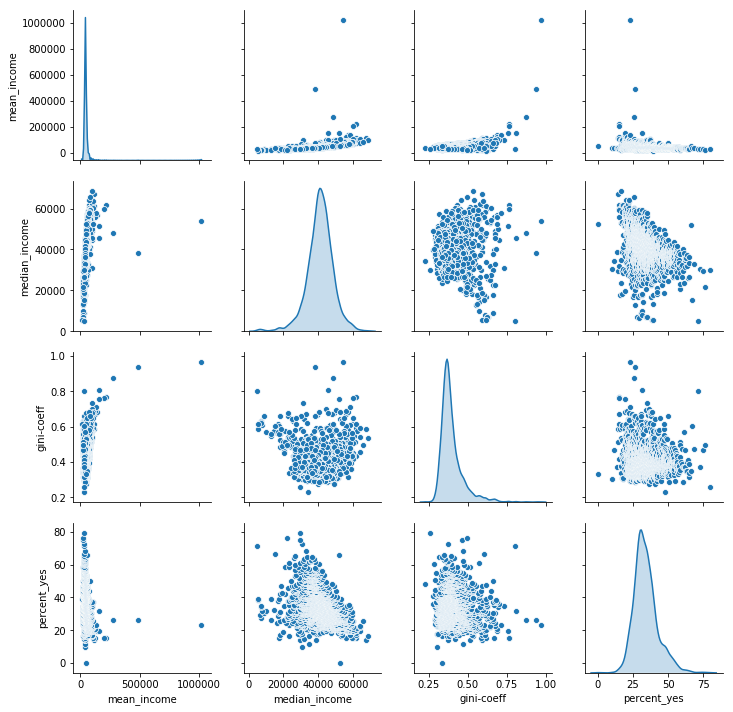

In [7]:
analysis_data =analysis.drop(columns=['n_taxed', 'turnout_perc','commune', 'bfsnr','vote_yes','vote_no'])

seaborn.pairplot(analysis_data,diag_kind="kde");


To visualise data on geographical map plots, a few adjustments have to be made to the polygons. That is, polygons have to be merged to form new polygons for the pooled communes in the canton BE.

In [8]:
# Deisswil bei Münchenbuchsee und Wiggiswil
# create data frame containing the two
deisswil_wiggiswil = pd.concat([geodata[geodata['GMDNAME']=='Deisswil bei Münchenbuchsee'], geodata[geodata['GMDNAME']=='Wiggiswil']])
# merge the polys
deisswilpoly =deisswil_wiggiswil.iat[0,16]
wiggiswilpoly =deisswil_wiggiswil.iat[1,16]
deisswilwiggiswilpoly=deisswilpoly.union(wiggiswilpoly)
# make a result df containing the new name and poly
df = gpd.GeoDataFrame({'GMDNAME':['Wiggiswil und Deisswil bei Münchenbuchsee'], 'geometry':[deisswilwiggiswilpoly]} )
# merge it back to the geodata data frame
geodata = pd.concat([geodata, df],sort=True)
# drop the now unneeded rows
geodata=geodata[geodata.GMDNAME != 'Wiggiswil']
geodata=geodata[geodata.GMDNAME != 'Deisswil bei Münchenbuchsee']

In [9]:
# Höchstetten und Hellsau
# create data frame containing the two
hoechst_hellsau = pd.concat([geodata[geodata['GMDNAME']=='Höchstetten'], geodata[geodata['GMDNAME']=='Hellsau']])
# merge the polys
hoechstpoly =hoechst_hellsau.iat[0,16]
hellsaupoly =hoechst_hellsau.iat[1,16]
hoechsthellsaupoly=hoechstpoly.union(hellsaupoly)
# make a result df containing the new name and poly
df = gpd.GeoDataFrame({'GMDNAME':['Höchstetten und Hellsau'], 'geometry':[hoechsthellsaupoly]} )
# merge it back to the geodata data frame
geodata = pd.concat([geodata, df],sort=True)
# drop the now unneeded rows
geodata=geodata[geodata.GMDNAME != 'Höchstetten']
geodata=geodata[geodata.GMDNAME != 'Hellsau']

In [10]:
# Ersigen, Niederösch, Oberösch
# create data frame containing the two
erniob = pd.concat([geodata[geodata['GMDNAME']=='Ersigen'], geodata[geodata['GMDNAME']=='Niederösch'],geodata[geodata['GMDNAME']=='Oberösch']])
# merge the polys
erspoly =erniob.iat[0,16]
nipoly =erniob.iat[1,16]
obpoly =erniob.iat[2,16]
erni=erspoly.union(nipoly)
erniobpoly=erni.union(obpoly)
# make a result df containing the new name and poly
df = gpd.GeoDataFrame({'GMDNAME':['Ersigen, Niederösch, Oberösch'], 'geometry':[erniobpoly]} )
# merge it back to the geodata data frame
geodata = pd.concat([geodata, df],sort=True)
# drop the now unneeded rows
geodata=geodata[geodata.GMDNAME != 'Ersigen']
geodata=geodata[geodata.GMDNAME != 'Niederösch']
geodata=geodata[geodata.GMDNAME != 'Oberösch']

In [11]:
# Wald und Niedermuhlern
# create data frame containing the two
wani= pd.concat([geodata[geodata['GMDNAME']=='Wald (BE)'], geodata[geodata['GMDNAME']=='Niedermuhlern']])
# merge the polys
wapoly =wani.iat[0,16]
nipoly =wani.iat[1,16]
wanipoly=wapoly.union(nipoly)
# make a result df containing the new name and poly
df = gpd.GeoDataFrame({'GMDNAME':['Wald und Niedermuhlern'], 'geometry':[wanipoly]} )
# merge it back to the geodata data frame
geodata = pd.concat([geodata, df],sort=True)
# drop the now unneeded rows
geodata=geodata[geodata.GMDNAME != 'Wald (BE)']
geodata=geodata[geodata.GMDNAME != 'Niedermuhlern']

In [12]:
# Münchenwiler und Clavaleyres
# create data frame containing the two
muecla= pd.concat([geodata[geodata['GMDNAME']=='Münchenwiler'], geodata[geodata['GMDNAME']=='Clavaleyres']])
# merge the polys
muepoly =muecla.iat[0,16]
clapoly =muecla.iat[1,16]
mueclapoly=muepoly.union(clapoly)
# make a result df containing the new name and poly
df = gpd.GeoDataFrame({'GMDNAME':['Münchenwiler und Clavaleyres'], 'geometry':[mueclapoly]} )
# merge it back to the geodata data frame
geodata = pd.concat([geodata, df],sort=True)
# drop the now unneeded rows
geodata=geodata[geodata.GMDNAME != 'Münchenwiler']
geodata=geodata[geodata.GMDNAME != 'Clavaleyres']

In [13]:
# Kirchdorf, Jaberg, Noflen
# create data frame containing the two
kijano = pd.concat([geodata[geodata['GMDNAME']=='Kirchdorf (BE)'], geodata[geodata['GMDNAME']=='Jaberg'],geodata[geodata['GMDNAME']=='Noflen']])
# merge the polys
kipoly =kijano.iat[0,16]
japoly =kijano.iat[1,16]
nopoly =kijano.iat[2,16]
kija=kipoly.union(japoly)
kijanopoly=kija.union(nopoly)
# make a result df containing the new name and poly
df = gpd.GeoDataFrame({'GMDNAME':['Kirchdorf, Jaberg, Noflen'], 'geometry':[kijanopoly]} )
# merge it back to the geodata data frame
geodata = pd.concat([geodata, df],sort=True)
# drop the now unneeded rows
geodata=geodata[geodata.GMDNAME != 'Kirchdorf (BE)']
geodata=geodata[geodata.GMDNAME != 'Jaberg']
geodata=geodata[geodata.GMDNAME != 'Noflen']

In [14]:
# Mötschwil und Rüti bei Lyssach
# create data frame containing the two
moerue= pd.concat([geodata[geodata['GMDNAME']=='Mötschwil'], geodata[geodata['GMDNAME']=='Rüti bei Lyssach']])
# merge the polys
moepoly =moerue.iat[0,16]
ruepoly =moerue.iat[1,16]
moeruepoly=moepoly.union(ruepoly)
# make a result df containing the new name and poly
df = gpd.GeoDataFrame({'GMDNAME':['Mötschwil und Rüti bei Lyssach'], 'geometry':[moeruepoly]} )
# merge it back to the geodata data frame
geodata = pd.concat([geodata, df],sort=True)
# drop the now unneeded rows
geodata=geodata[geodata.GMDNAME != 'Mötschwil']
geodata=geodata[geodata.GMDNAME != 'Rüti bei Lyssach']

Now that these polygons are merged, check if there are any more differences between commune names:

In [15]:

# names of communes in the analysis dataset that are not in the geodata
np.setdiff1d(analysis["commune"].tolist(),geodata["GMDNAME"].tolist())


array([], dtype='<U41')

This array is empty, e.g there are no communes in the analysis dataset that are NOT in geodata

In [16]:
# names of geodata communes that are not in the analyis dataset
np.setdiff1d(geodata["GMDNAME"].tolist(),analysis["commune"].tolist())

array(['Comunanza Cadenazzo/Monteceneri', 'Comunanza Capriasca/Lugano',
       'Kommunanz Reckingen-Gluringen/Grafschaft', 'Staatswald Galm'],
      dtype='<U41')

This array contains a few names but these areas either belong to more than one commune (Kommunanz)

- https://de.wikipedia.org/wiki/Kommunanz_Cadenazzo/Monteceneri
- https://de.wikipedia.org/wiki/Kommunanz_Capriasca/Lugano
- https://de.wikipedia.org/wiki/Kommunanz_Reckingen-Gluringen/Grafschaft

or to the canton and thus no commune

- https://de.wikipedia.org/wiki/Staatswald_Galm

Thus these regions are left unchanged.

Before the two datasets can be merged, column name has to be renamed 

In [17]:
geodata = geodata.rename(columns={"GMDNAME": "commune"})

Finally, geodata and analysis datasets can be merged:

In [18]:
# with this merge we lose the aforementioned areas that are in the geodata but not in the votedata so on a plot they will not be shown
alldata = geodata.merge(analysis, on='commune')
# check if the merge was successful:
alldata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2343 entries, 0 to 2342
Data columns (total 28 columns):
AREA_HA          2336 non-null float64
BZNR             2336 non-null float64
commune          2343 non-null object
GMDNR            2336 non-null float64
GRNR             2336 non-null float64
KTNR             2336 non-null float64
X_CNTR           2336 non-null float64
X_MAX            2336 non-null float64
X_MIN            2336 non-null float64
Y_CNTR           2336 non-null float64
Y_MAX            2336 non-null float64
Y_MIN            2336 non-null float64
Z_AVG            2336 non-null float64
Z_MAX            2336 non-null float64
Z_MED            2336 non-null float64
Z_MIN            2336 non-null float64
geometry         2343 non-null object
vote_yes         2343 non-null int64
vote_no          2343 non-null int64
turnout_perc     2343 non-null float64
canton           2343 non-null object
canton_name      2343 non-null object
bfsnr            2343 non-null int6

looking alright! So map plots can be created based on this. 

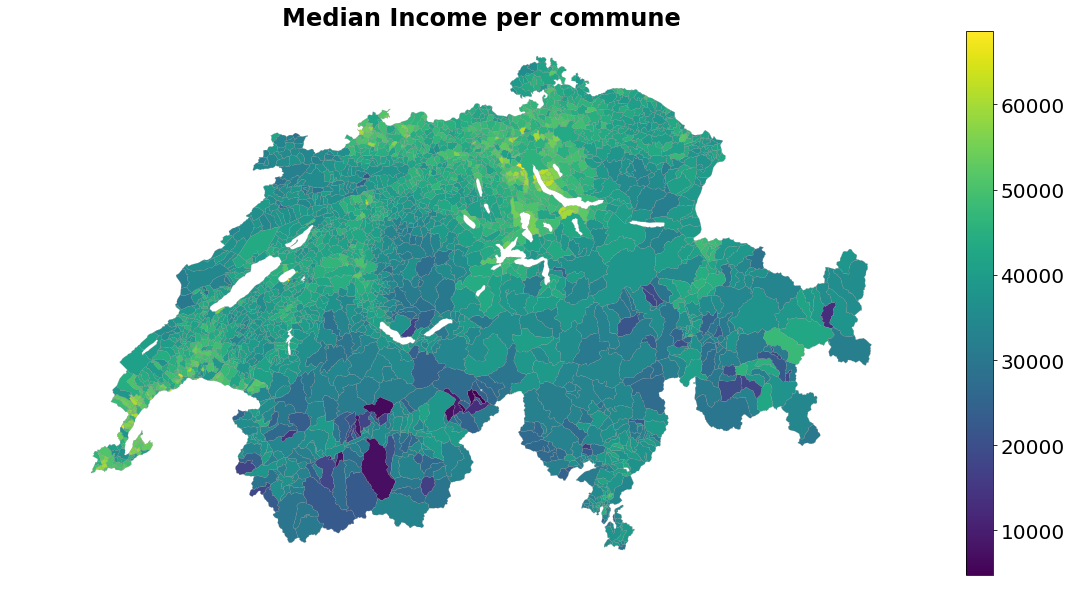

In [19]:
# plot median income on the map:
#================================
# For this plot the colormap viridis is used
variable = 'median_income'

# set the range for the choropleth
vmin, vmax = min(alldata["median_income"]), max(alldata["median_income"])

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 10))
# create map using median income as variable, viridis color map, no transparency and a grey outline around the polygons of width 0.2
alldata.plot(column=variable, cmap="viridis",alpha=1, linewidth=0.2, ax=ax, edgecolor='gray')
# remove the axis
ax.axis('off')

# add a nice readable title
ax.set_title('Median Income per commune', \
              fontdict={'fontsize': '24',
                        'fontweight' : 'bold'})
# Create colorbar as a legend
colorbar = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=vmin, vmax=vmax))

colorbar._A = []
cbar = fig.colorbar(colorbar)
cbar.ax.tick_params(labelsize=20)

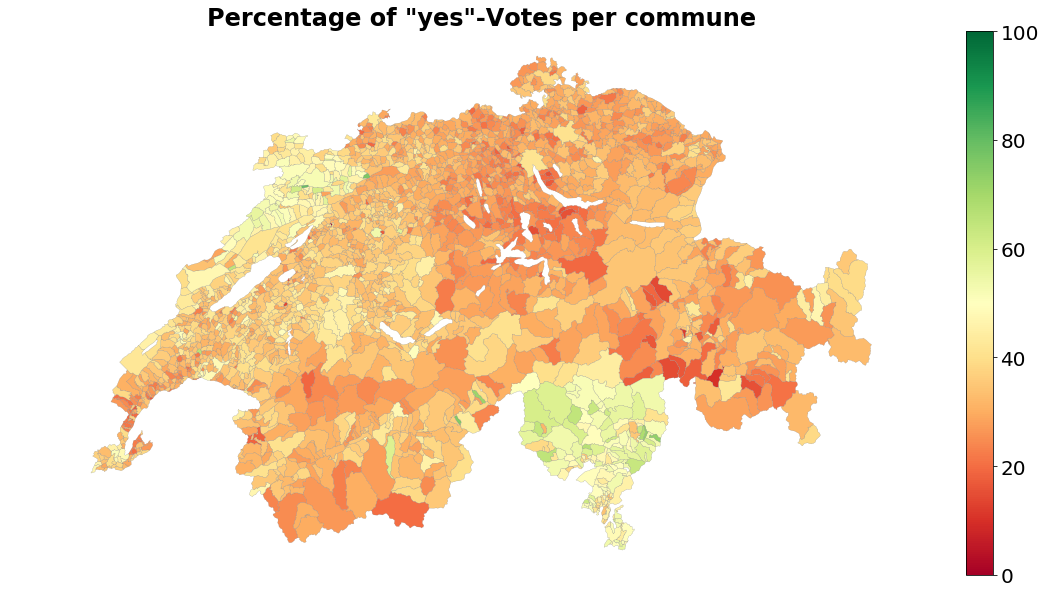

In [20]:
# plot 'yes'-percentage on the map:
#================================
# for this plot i want the colormap to go from red (low yes percentage) to yellow (50% yes, 50% no), to green (high yes percentage), thus i use RdYlGn
variable = 'percent_yes'
# for the plot to look nice i would like the range of the colormap that is used in the plot to range from 0 to 100 and not the actual range of the variable. 
# for this to be possible i found no adequate way but an ugly workaround - so please if anyone knows let me know how to deal with this in  a better way!

# workaround: we have 1 commune with 0 yes percentage. Add a row with a yes percentage value of 100 just for this plot:
newrow = gpd.GeoDataFrame({'percent_yes':[100]})   
# merge it back to the geodata data frame
plot_data = pd.concat([alldata, newrow], sort=True)


# set the range for the choropleth
vmin, vmax = min(plot_data["percent_yes"]), max(plot_data["percent_yes"])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 10))
# create map using yes percentage as variable, RdYlGn color map, no transparency and a grey outline around the polygons of width 0.2
plot_data.plot(column=variable, cmap="RdYlGn",alpha=1, linewidth=0.2, ax=ax, edgecolor='gray')
# remove the axis
ax.axis('off')

# add a nice readable title
ax.set_title('Percentage of "yes"-Votes per commune', \
              fontdict={'fontsize': '24',
                        'fontweight' : 'bold'})
# Create colorbar as a legend
colorbar = plt.cm.ScalarMappable(cmap="RdYlGn", norm=plt.Normalize(vmin=vmin, vmax=vmax))

colorbar._A = []
cbar = fig.colorbar(colorbar)
cbar.ax.tick_params(labelsize=20)

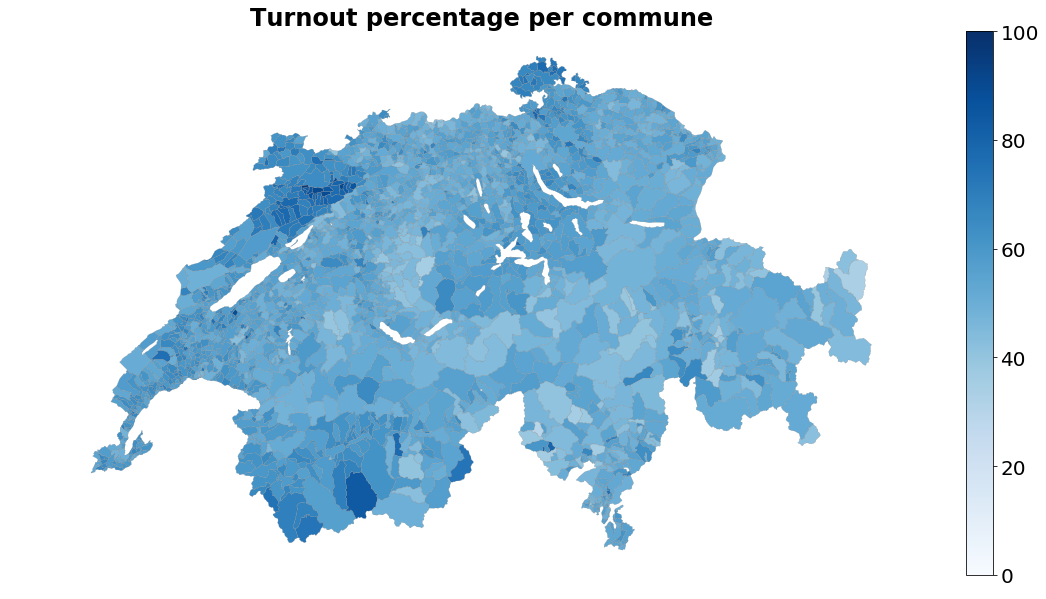

In [21]:
# plot turnout-percentage on the map:
#================================
# for this plot i want the colormap to go from white (low turnout rate) to deep blue (high turnout rate), thus i use Blues
variable = 'turnout_perc'
# for the plot to look nice i would like the range of the colormap that is used in the plot to range from 0 to 100 and not the actual range of the variable. 
# for this to be possible i found no adequate way but an ugly workaround - so please if anyone knows let me know how to deal with this in  a better way!

# workaround: we have 1 commune with 0 turnout percentage. Add a row with a turnout percentage value of 100 just for this plot:
newrow = gpd.GeoDataFrame({'turnout_perc':[100]})   
# merge it back to the geodata data frame
plot_data = pd.concat([alldata, newrow], sort=True)


# set the range for the choropleth
vmin, vmax = min(plot_data["turnout_perc"]), max(plot_data["turnout_perc"])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 10))
# create map using turnout rate as variable, Blues color map, no transparency and a grey outline around the polygons of width 0.2
plot_data.plot(column=variable, cmap="Blues",alpha=1, linewidth=0.2, ax=ax, edgecolor='gray')
# remove the axis
ax.axis('off')

# add a nice readable title
ax.set_title('Turnout percentage per commune', \
              fontdict={'fontsize': '24',
                        'fontweight' : 'bold'})
# Create colorbar as a legend
colorbar = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))

colorbar._A = []
cbar = fig.colorbar(colorbar)
cbar.ax.tick_params(labelsize=20)

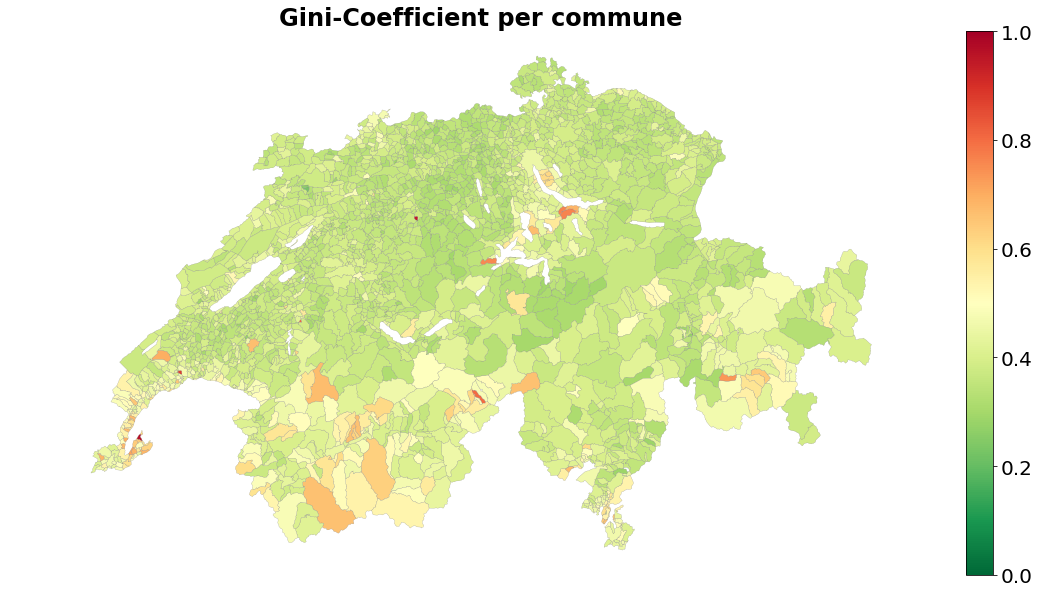

In [22]:
# plot gini-coefficient on the map:
#================================
# for this plot i want the colormap to go from green (low gini coefficient) to yellow to red (high gini coefficient), thus i use again RdYlGn but reversed
variable = 'gini-coeff'
# for the plot to look nice i would like the range of the colormap that is used in the plot to range from 0 to 1 and not the actual range of the variable. 
# for this to be possible i found no adequate way but an ugly workaround - so please if anyone knows let me know how to deal with this in  a better way!

# workaround: we no commune with 0 or with 1 value on the gini coefficient. Add 2 rows that contain these values
newrow = gpd.GeoDataFrame({'gini-coeff':[1]})  
newrow_two = gpd.GeoDataFrame({'gini-coeff':[0]}) 
# merge them back to the geodata data frame
plot_data = pd.concat([alldata, newrow], sort=True)
plot_data = pd.concat([plot_data, newrow_two], sort=True)

# set the range for the choropleth
vmin, vmax = min(plot_data["gini-coeff"]), max(plot_data["gini-coeff"])

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 10))
# create map using gini coefficient as variable, reversed RdYlGn color map, no transparency and a grey outline around the polygons of width 0.2
plot_data.plot(column=variable, cmap="RdYlGn_r",alpha=1, linewidth=0.2, ax=ax, edgecolor='gray')
# remove the axis
ax.axis('off')

# add a nice readable title
ax.set_title('Gini-Coefficient per commune', \
              fontdict={'fontsize': '24',
                        'fontweight' : 'bold'})
# Create colorbar as a legend
colorbar = plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))

colorbar._A = []
cbar = fig.colorbar(colorbar)
cbar.ax.tick_params(labelsize=20)

These plots look ok but they are not interactive. To create interactive map plots, the Bokeh library comes in handy:
Let's see what happens if we just plot the data with pandas bokeh:

In [24]:
#pandas_bokeh.output_notebook() # to display the output in the jupyter notebook and not a separate html file
pandas_bokeh.output_file("Interactive Plot.html")
#alldata.plot_bokeh()

This already produces a zoomable plot and even includes OpenStreetMap data! 
But for this project it is more important to have clean informative plots that actually show analysis variables and additional information. 

In [25]:
# let's create the plots as interactive plots
# yes percentage:
#=================
# for some reason, plot_bokeh implements reversed color maps thus a workaround to display correctly what we want is to add new columns like this
alldata["percent_no"]=1-alldata["percent_yes"]
from bokeh.palettes import RdYlGn11 as palette1
from bokeh.palettes import Blues9 as palette2
palette1.reverse()
palette2.reverse()
fig =alldata.plot_bokeh(
    category="percent_no", # select the variable
    show_figure=False, # don't show the figure yet
    show_colorbar=False, # don't show the colorbar automatically as it will be added separately
    colormap="RdYlGn", # red yellow green colormap
    line_color="gray", # grey polygon outline
    title = "Percentage of 'yes' votes per commune", # add title
    xlabel=None,
    ylabel=None,
    # now it gets interesting: display information as the user hovers over a commune: commune name, number of yes votes, number of no votes and the canton!
    hovertool_string="""<h2> @{commune} </h2> 
    
                        <h3> Canton: @{canton} </h3>
                        <h3> Number of 'yes' votes: @{vote_yes}</h3>
                        <h3> Number of 'no' votes: @{vote_no} </h3>
                        <h3> Percentage of 'yes' votes: @{percent_yes}{0.2f}% </h3>""",
    legend=False, # no legend
    fill_alpha=1,
    tile_provider=None, # no tile provider, e.g. we don't want for example OSM map displayed
    toolbar_location=None # no toolbar
)
# remove axis and grid
fig.xgrid.visible = False
fig.ygrid.visible = False
fig.axis.visible = False

# set up mapper and colorbar
color_mapper = LinearColorMapper(palette=palette1, low=min(alldata["percent_yes"]), high=max(alldata["percent_yes"]))
color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))
# add the colorbar
fig.add_layout(color_bar, 'right')

# gini coefficient:
#=================

fig2=alldata.plot_bokeh(
    category="gini-coeff",
    colormap="RdYlGn",
    title = "Gini-Coefficient per commune",
    show_colorbar=False,
    show_figure=False,
    line_color="gray",
    tile_provider=None,
    toolbar_location=None,
    fill_alpha=1,
    colormap_uselog=True,
    hovertool_string="""<h2> @{commune} </h2> 
    
                        <h3> Canton: @{canton} </h3>
                        <h3> Gini-Coefficient: @{gini-coeff}{0.2f} </h3>""",
    legend=False
)

fig2.xgrid.visible = False
fig2.ygrid.visible = False
fig2.axis.visible = False
palette2.reverse()
color_mapper2 = LinearColorMapper(palette="RdYlGn11", low=min(alldata["gini-coeff"]), high=max(alldata["gini-coeff"]))
color_bar2 = ColorBar(color_mapper=color_mapper2, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

fig2.add_layout(color_bar2, 'right')

# median income
#===============
fig3=alldata.plot_bokeh(
    category="median_income",
    colormap="Viridis",
    title = "Median income per commune",
    show_colorbar=False,
    show_figure=False,
    line_color="gray",
    tile_provider=None,
    toolbar_location=None,
    fill_alpha=1,
    colormap_uselog=True,
    hovertool_string="""<h2> @{commune} </h2> 
    
                        <h3> Canton: @{canton} </h3>
                        <h3> Median income: @{median_income}{0.2f} </h3>""",
    legend=False
)

fig3.xgrid.visible = False
fig3.ygrid.visible = False
fig3.axis.visible = False

color_mapper3 = LinearColorMapper(palette="Viridis256", low=min(alldata["median_income"]), high=max(alldata["median_income"]))
color_bar3 = ColorBar(color_mapper=color_mapper3, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

fig3.add_layout(color_bar3, 'right')

# plot all the 3 figures in 1 plot as a plot grid and remove the toolbar from the overall plot
allplots=pandas_bokeh.plot_grid([[fig, fig2], [fig3, None]], 
                            plot_width=700,
                            toolbar_location=None)



## 3. Correlation analysis

To answer the aforementioned research questions, correlations have to be examined.

In [31]:
# create a dataframe containing only the relevant variables
corrdata =analysis.drop(columns=['commune', 'vote_yes','vote_no','turnout_perc', 'canton', 'canton_name', 'bfsnr', 'n_taxed'])

In [39]:
# can we use pearson correlations? Are the variables normally distributed?
# shapiro test for normality - significant result indicates that the data was drawn from a normal distribution.
print(scipy.stats.shapiro(corrdata['mean_income']))
print(scipy.stats.shapiro(corrdata['percent_yes']))
print(scipy.stats.shapiro(corrdata['gini-coeff']))
print(scipy.stats.shapiro(corrdata['median_income']))

(0.27283793687820435, 0.0)
(0.9572923183441162, 1.1232436355046436e-25)
(0.8240447044372559, 5.605193857299268e-45)
(0.9699902534484863, 9.843897614810685e-22)


Variables are normally distributed so pearson correlations are used

In [41]:
corr=corrdata.corr(method='pearson')
corr

,mean_income,median_income,gini-coeff,percent_yes
mean_income,1.000000,0.406749,0.428746,-0.220348
median_income,0.406749,1.000000,-0.077555,-0.389167
gini-coeff,0.428746,-0.077555,1.000000,-0.056398
percent_yes,-0.220348,-0.389167,-0.056398,1.000000


again, print a nice latex table output

In [43]:
print(corr.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  mean\_income &  median\_income &  gini-coeff &  percent\_yes \\
\midrule
mean\_income   &     1.000000 &       0.406749 &    0.428746 &    -0.220348 \\
median\_income &     0.406749 &       1.000000 &   -0.077555 &    -0.389167 \\
gini-coeff    &     0.428746 &      -0.077555 &    1.000000 &    -0.056398 \\
percent\_yes   &    -0.220348 &      -0.389167 &   -0.056398 &     1.000000 \\
\bottomrule
\end{tabular}



looks like only median income has a slight correlation with vote result. This result can be visualised with seaborn bivariate scatterplots:

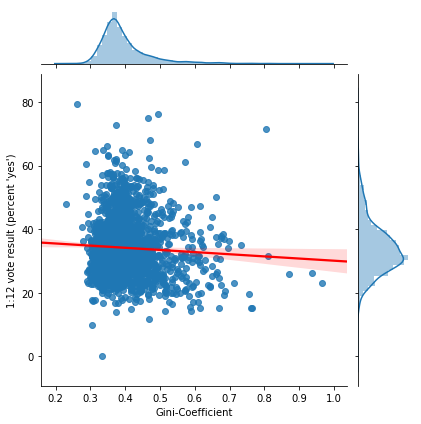

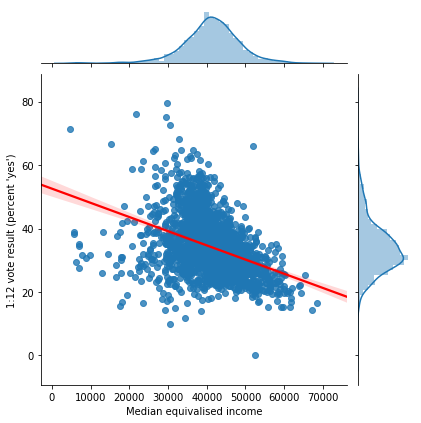

In [51]:
# plot bivariate scatterplots

# plot gini-coefficient and vote result correlation, also fit regression line with error
seaborn.jointplot(x="gini-coeff", y="percent_yes", data=corrdata, kind='reg',
                  joint_kws={'line_kws':{'color':'red'}})
plt.xlabel("Gini-Coefficient");
plt.ylabel("1:12 vote result (percent 'yes')");


# plot median income and vote result correlation, also fit regression line with error
seaborn.jointplot(x="median_income", y="percent_yes", data=corrdata, kind='reg',
                  joint_kws={'line_kws':{'color':'red'}})
plt.xlabel("Median equivalised income");
plt.ylabel("1:12 vote result (percent 'yes')");


plt.show()


Interpreting the regressions:

In [53]:
# perform the actual regression analysis for median income and vote result:
y = corrdata['percent_yes']
x = corrdata['median_income']
# to apply Linear Regression from sklearn the variables have to be reshaped first
x = np.array(x).reshape((-1, 1))
y = np.array(y)
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


coefficient of determination: 0.15145074099240297
intercept: 52.56642075532764
slope: [-0.00044709]


In [56]:
# is this regression 'significant'? To obtain F statistic and actual p-values, a different method is required, namely statsmodels api is used
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     417.8
Date:                Fri, 27 Sep 2019   Prob (F-statistic):           1.39e-85
Time:                        15:58:42   Log-Likelihood:                -8149.0
No. Observations:                2343   AIC:                         1.630e+04
Df Residuals:                    2341   BIC:                         1.631e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.5664      0.915     57.453      0.0

Correlations by canton:

In [61]:
corrdata2=analysis.drop(columns=['commune', 'vote_yes','vote_no','turnout_perc', 'canton_name', 'bfsnr', 'n_taxed'])
by_canton = corrdata2.groupby("canton")

In [62]:
def get_corr(canton):
    corr = scipy.stats.pearsonr(by_canton.get_group(canton)["median_income"],
                           by_canton.get_group(canton)["percent_yes"])
    return corr

In [63]:
# Pearson correlation between median income and vote result per canton

zhcorr=get_corr("ZH")
print("association between mean income and vote result - ZH")
print(zhcorr)

becorr=get_corr("BE")
print("\nassociation between mean income and vote result - BE")
print(becorr)

gecorr=get_corr("GE")
print("\nassociation between mean income and vote result - GE")
print(gecorr)

blcorr=get_corr("BL")
print("\nassociation between mean income and vote result - BL")
print(blcorr)

bscorr= get_corr("BS")
print("\nassociation between mean income and vote result - BS")
print(bscorr)

urcorr=get_corr("UR")
print("\nassociation between mean income and vote result - UR")
print(urcorr)

jucorr=get_corr("JU")
print("\nassociation between mean income and vote result - JU")
print(jucorr)

ticorr=get_corr("TI")
print("\nassociation between mean income and vote result - TI")
print(ticorr)

grcorr=get_corr("GR")
print("\nassociation between mean income and vote result - GR")
print(grcorr)

zgcorr=get_corr("ZG")
print("\nassociation between mean income and vote result - ZG")
print(zgcorr)

frcorr=get_corr("FR")
print("\nassociation between mean income and vote result - FR")
print(frcorr)

necorr=get_corr("NE")
print("\nassociation between mean income and vote result - NE")
print(necorr)

arcorr=get_corr("AR")
print("\nassociation between mean income and vote result - AR")
print(arcorr)

aicorr=get_corr("AI")
print("\nassociation between mean income and vote result - AI")
print(aicorr)

vscorr=get_corr("VS")
print("\nassociation between mean income and vote result - VS")
print(vscorr)

vdcorr=get_corr("VD")
print("\nassociation between mean income and vote result - VD")
print(vdcorr)

glcorr= get_corr("GL")
print("\nassociation between mean income and vote result - GL")
print(glcorr)

socorr=get_corr("SO")
print("\nassociation between mean income and vote result - SO")
print(socorr)

agcorr=get_corr("AG")
print("\nassociation between mean income and vote result - AG")
print(agcorr)

lucorr=get_corr("LU")
print("\nassociation between mean income and vote result - LU")
print(lucorr)

szcorr=get_corr("SZ")
print("\nassociation between mean income and vote result - SZ")
print(szcorr)

owcorr=get_corr("OW")
print("\nassociation between mean income and vote result - OW")
print(owcorr)

nwcorr=get_corr("NW")
print("\nassociation between mean income and vote result - NW")
print(nwcorr)

tgcorr=get_corr("TG")
print("\nassociation between mean income and vote result - TG")
print(tgcorr)

sgcorr=get_corr("SG")
print("\nassociation between mean income and vote result - SG")
print(sgcorr)

shcorr=get_corr("SH")
print("\nassociation between mean income and vote result - Sh")
print(shcorr)



association between mean income and vote result - ZH
(-0.705987582461293, 5.834410135388026e-27)

association between mean income and vote result - BE
(-0.30719019680887955, 3.7643324501437465e-09)

association between mean income and vote result - GE
(-0.741663275737299, 5.592782085176838e-09)

association between mean income and vote result - BL
(-0.6541824445638216, 8.479606156370596e-12)

association between mean income and vote result - BS
(-0.9996086350646788, 0.017811489607527507)

association between mean income and vote result - UR
(-0.09447527486674619, 0.6919652291190055)

association between mean income and vote result - JU
(0.10402453326754943, 0.44126364710683996)

association between mean income and vote result - TI
(-0.3049385788810716, 0.0003229489805127944)

association between mean income and vote result - GR
(0.134054771037691, 0.10671043396088549)

association between mean income and vote result - ZG
(-0.2603712683467695, 0.43936751667648966)

association between m

correlations summarised for half-cantons

In [90]:
ow = alldata.query('canton=="NW" | canton=="OW"')
owcorr=scipy.stats.pearsonr(ow["median_income"],
                           ow["percent_yes"])


bs = alldata.query('canton=="BS" | canton=="BL"')
bscorr=scipy.stats.pearsonr(bs["median_income"],
                           bs["percent_yes"])

ap = alldata.query('canton=="AI" | canton=="AR"')
apcorr=scipy.stats.pearsonr(ap["median_income"],
                           ap["percent_yes"])


Plotting correlation strength on a geographical map

In [92]:
# this code is very ugly and i know it. all my attempts to write a working function failed because i suck at GeoPandas for some reason. Sorry!

zhall=alldata.query('canton=="ZH"')
zhlist=zhall["commune"].tolist()
one=zhall[zhall['commune']=="Bonstetten"]
onepoly=one.iat[0,16]
zhpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in zhlist:
    one=zhall[zhall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    zhpoly=zhpoly.union(onepoly)
    
beall=alldata.query('canton=="BE"')
belist=beall["commune"].tolist()
one=beall[beall['commune']=="Thun"]
onepoly=one.iat[0,16]
bepoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in belist:
    one=beall[beall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    bepoly=bepoly.union(onepoly)

bsall=alldata.query('canton=="BS" | canton=="BL"')
bslist=bsall["commune"].tolist()
one=bsall[bsall['commune']=="Basel"]
onepoly=one.iat[0,16]
bspoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in bslist:
    one=bsall[bsall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    bspoly=bspoly.union(onepoly)
    
tiall=alldata.query('canton=="TI"')
tilist=tiall["commune"].tolist()
one=tiall[tiall['commune']=="Lugano"]
onepoly=one.iat[0,16]
tipoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in tilist:
    one=tiall[tiall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    tipoly=tipoly.union(onepoly)

vsall=alldata.query('canton=="VS"')
vslist=vsall["commune"].tolist()
one=vsall[vsall['commune']=="Sion"]
onepoly=one.iat[0,16]
vspoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in vslist:
    one=vsall[vsall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    vspoly=vspoly.union(onepoly)
    
vdall=alldata.query('canton=="VD"')
vdlist=vdall["commune"].tolist()
one=vdall[vdall['commune']=="Lausanne"]
onepoly=one.iat[0,16]
vdpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in vdlist:
    one=vdall[vdall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    vdpoly=vdpoly.union(onepoly)

grall=alldata.query('canton=="GR"')
grlist=grall["commune"].tolist()
one=grall[grall['commune']=="Chur"]
onepoly=one.iat[0,16]
grpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in grlist:
    one=grall[grall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    grpoly=grpoly.union(onepoly)

juall=alldata.query('canton=="JU"')
julist=juall["commune"].tolist()
one=juall[juall['commune']=="Delémont"]
onepoly=one.iat[0,16]
jupoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in julist:
    one=juall[juall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    jupoly=jupoly.union(onepoly)   
    
apall=alldata.query('canton=="AI" | canton=="AR"')
aplist=apall["commune"].tolist()
one=apall[apall['commune']=="Herisau"]
onepoly=one.iat[0,16]
appoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in aplist:
    one=apall[apall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    appoly=appoly.union(onepoly)

owall=alldata.query('canton=="NW" | canton=="OW"')
owlist=owall["commune"].tolist()
one=owall[owall['commune']=="Stans"]
onepoly=one.iat[0,16]
owpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in owlist:
    one=owall[owall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    owpoly=owpoly.union(onepoly)
    
neall=alldata.query('canton=="NE"')
nelist=neall["commune"].tolist()
one=neall[neall['commune']=="Neuchâtel"]
onepoly=one.iat[0,16]
nepoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in nelist:
    one=neall[neall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    nepoly=nepoly.union(onepoly)
    
geall=alldata.query('canton=="GE"')
gelist=geall["commune"].tolist()
one=geall[geall['commune']=="Genève"]
onepoly=one.iat[0,16]
gepoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in gelist:
    one=geall[geall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    gepoly=gepoly.union(onepoly)

sgall=alldata.query('canton=="SG"')
sglist=sgall["commune"].tolist()
one=sgall[sgall['commune']=="Nesslau"]
onepoly=one.iat[0,16]
sgpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in sglist:
    one=sgall[sgall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    sgpoly=sgpoly.union(onepoly)

agall=alldata.query('canton=="AG"')
aglist=agall["commune"].tolist()
one=agall[agall['commune']=="Aarau"]
onepoly=one.iat[0,16]
agpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in aglist:
    one=agall[agall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    agpoly=agpoly.union(onepoly)   
    
tgall=alldata.query('canton=="TG"')
tglist=tgall["commune"].tolist()
one=tgall[tgall['commune']=="Frauenfeld"]
onepoly=one.iat[0,16]
tgpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in tglist:
    one=tgall[tgall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    tgpoly=tgpoly.union(onepoly)

urall=alldata.query('canton=="UR"')
urlist=urall["commune"].tolist()
one=urall[urall['commune']=="Erstfeld"]
onepoly=one.iat[0,16]
urpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in urlist:
    one=urall[urall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    urpoly=urpoly.union(onepoly)
    
szall=alldata.query('canton=="SZ"')
szlist=szall["commune"].tolist()
one=szall[szall['commune']=="Schwyz"]
onepoly=one.iat[0,16]
szpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in szlist:
    one=szall[szall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    szpoly=szpoly.union(onepoly)

zgall=alldata.query('canton=="ZG"')
zglist=zgall["commune"].tolist()
one=zgall[zgall['commune']=="Zug"]
onepoly=one.iat[0,16]
zgpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in zglist:
    one=zgall[zgall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    zgpoly=zgpoly.union(onepoly)

luall=alldata.query('canton=="LU"')
lulist=luall["commune"].tolist()
one=luall[luall['commune']=="Luzern"]
onepoly=one.iat[0,16]
lupoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in lulist:
    one=luall[luall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    lupoly=lupoly.union(onepoly)

frall=alldata.query('canton=="FR"')
frlist=frall["commune"].tolist()
one=frall[frall['commune']=="Rue"]
onepoly=one.iat[0,16]
frpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in frlist:
    one=frall[frall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    frpoly=frpoly.union(onepoly) 
    
glall=alldata.query('canton=="GL"')
gllist=glall["commune"].tolist()
one=glall[glall['commune']=="Glarus"]
onepoly=one.iat[0,16]
glpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in gllist:
    one=glall[glall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    glpoly=glpoly.union(onepoly)

shall=alldata.query('canton=="SH"')
shlist=shall["commune"].tolist()
one=shall[shall['commune']=="Schaffhausen"]
onepoly=one.iat[0,16]
shpoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in shlist:
    one=shall[shall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    shpoly=shpoly.union(onepoly)
    
soall=alldata.query('canton=="SO"')
solist=soall["commune"].tolist()
one=soall[soall['commune']=="Solothurn"]
onepoly=one.iat[0,16]
sopoly = gpd.GeoDataFrame({'geometry':[onepoly]})

for i in solist:
    one=soall[soall['commune']==i]
    onepoly=one.iat[0,16]
    #print(onepoly)
    sopoly=sopoly.union(onepoly)

In [93]:
zh = gpd.GeoDataFrame({'canton':['ZH'],'corr':[zhcorr[0]], 'geometry':zhpoly} )
be = gpd.GeoDataFrame({'canton':['BE'],'corr':[becorr[0]], 'geometry':bepoly} )
sg = gpd.GeoDataFrame({'canton':['SG'],'corr':[sgcorr[0]], 'geometry':sgpoly} )
sh = gpd.GeoDataFrame({'canton':['SH'],'corr':[shcorr[0]], 'geometry':shpoly} )
tg = gpd.GeoDataFrame({'canton':['TG'],'corr':[tgcorr[0]], 'geometry':tgpoly} )
ag = gpd.GeoDataFrame({'canton':['AG'],'corr':[agcorr[0]], 'geometry':agpoly} )
ur = gpd.GeoDataFrame({'canton':['UR'],'corr':[urcorr[0]], 'geometry':urpoly} )
gl = gpd.GeoDataFrame({'canton':['GL'],'corr':[glcorr[0]], 'geometry':glpoly} )
bs = gpd.GeoDataFrame({'canton':['BL & BS'],'corr':[bscorr[0]], 'geometry':bspoly} )
ow = gpd.GeoDataFrame({'canton':['OW & NW'],'corr':[owcorr[0]], 'geometry':owpoly} )
ap = gpd.GeoDataFrame({'canton':['AI & AR'],'corr':[apcorr[0]], 'geometry':appoly} )
ge = gpd.GeoDataFrame({'canton':['GE'],'corr':[gecorr[0]], 'geometry':gepoly} )
fr = gpd.GeoDataFrame({'canton':['FR'],'corr':[frcorr[0]], 'geometry':frpoly} )
gr = gpd.GeoDataFrame({'canton':['GR'],'corr':[grcorr[0]], 'geometry':grpoly} )
sz = gpd.GeoDataFrame({'canton':['SZ'],'corr':[szcorr[0]], 'geometry':szpoly} )
zg = gpd.GeoDataFrame({'canton':['ZG'],'corr':[zgcorr[0]], 'geometry':zgpoly} )
ne = gpd.GeoDataFrame({'canton':['NE'],'corr':[necorr[0]], 'geometry':nepoly} )
vs = gpd.GeoDataFrame({'canton':['VS'],'corr':[vscorr[0]], 'geometry':vspoly} )
vd = gpd.GeoDataFrame({'canton':['VD'],'corr':[vdcorr[0]], 'geometry':vdpoly} )
so = gpd.GeoDataFrame({'canton':['SO'],'corr':[socorr[0]], 'geometry':sopoly} )
ti = gpd.GeoDataFrame({'canton':['TI'],'corr':[ticorr[0]], 'geometry':tipoly} )
ju = gpd.GeoDataFrame({'canton':['JU'],'corr':[jucorr[0]], 'geometry':jupoly} )
lu = gpd.GeoDataFrame({'canton':['LU'],'corr':[lucorr[0]], 'geometry':lupoly} )

cantondata= pd.concat([zh, be])
cantondata= pd.concat([cantondata, sg])
cantondata= pd.concat([cantondata, sh])
cantondata= pd.concat([cantondata, tg])
cantondata= pd.concat([cantondata, ag])
cantondata= pd.concat([cantondata, ur])
cantondata= pd.concat([cantondata, gl])
cantondata= pd.concat([cantondata, bs])
cantondata= pd.concat([cantondata, ow])
cantondata= pd.concat([cantondata, ap])
cantondata= pd.concat([cantondata, ge])
cantondata= pd.concat([cantondata, fr])
cantondata= pd.concat([cantondata, gr])
cantondata= pd.concat([cantondata, sz])
cantondata= pd.concat([cantondata, zg])
cantondata= pd.concat([cantondata, ne])
cantondata= pd.concat([cantondata, vs])
cantondata= pd.concat([cantondata, vd])
cantondata= pd.concat([cantondata, so])
cantondata= pd.concat([cantondata, ti])
cantondata= pd.concat([cantondata, ju])
cantondata= pd.concat([cantondata, lu])


AttributeError: ("'float' object has no attribute 'centroid'", 'occurred at index 0')

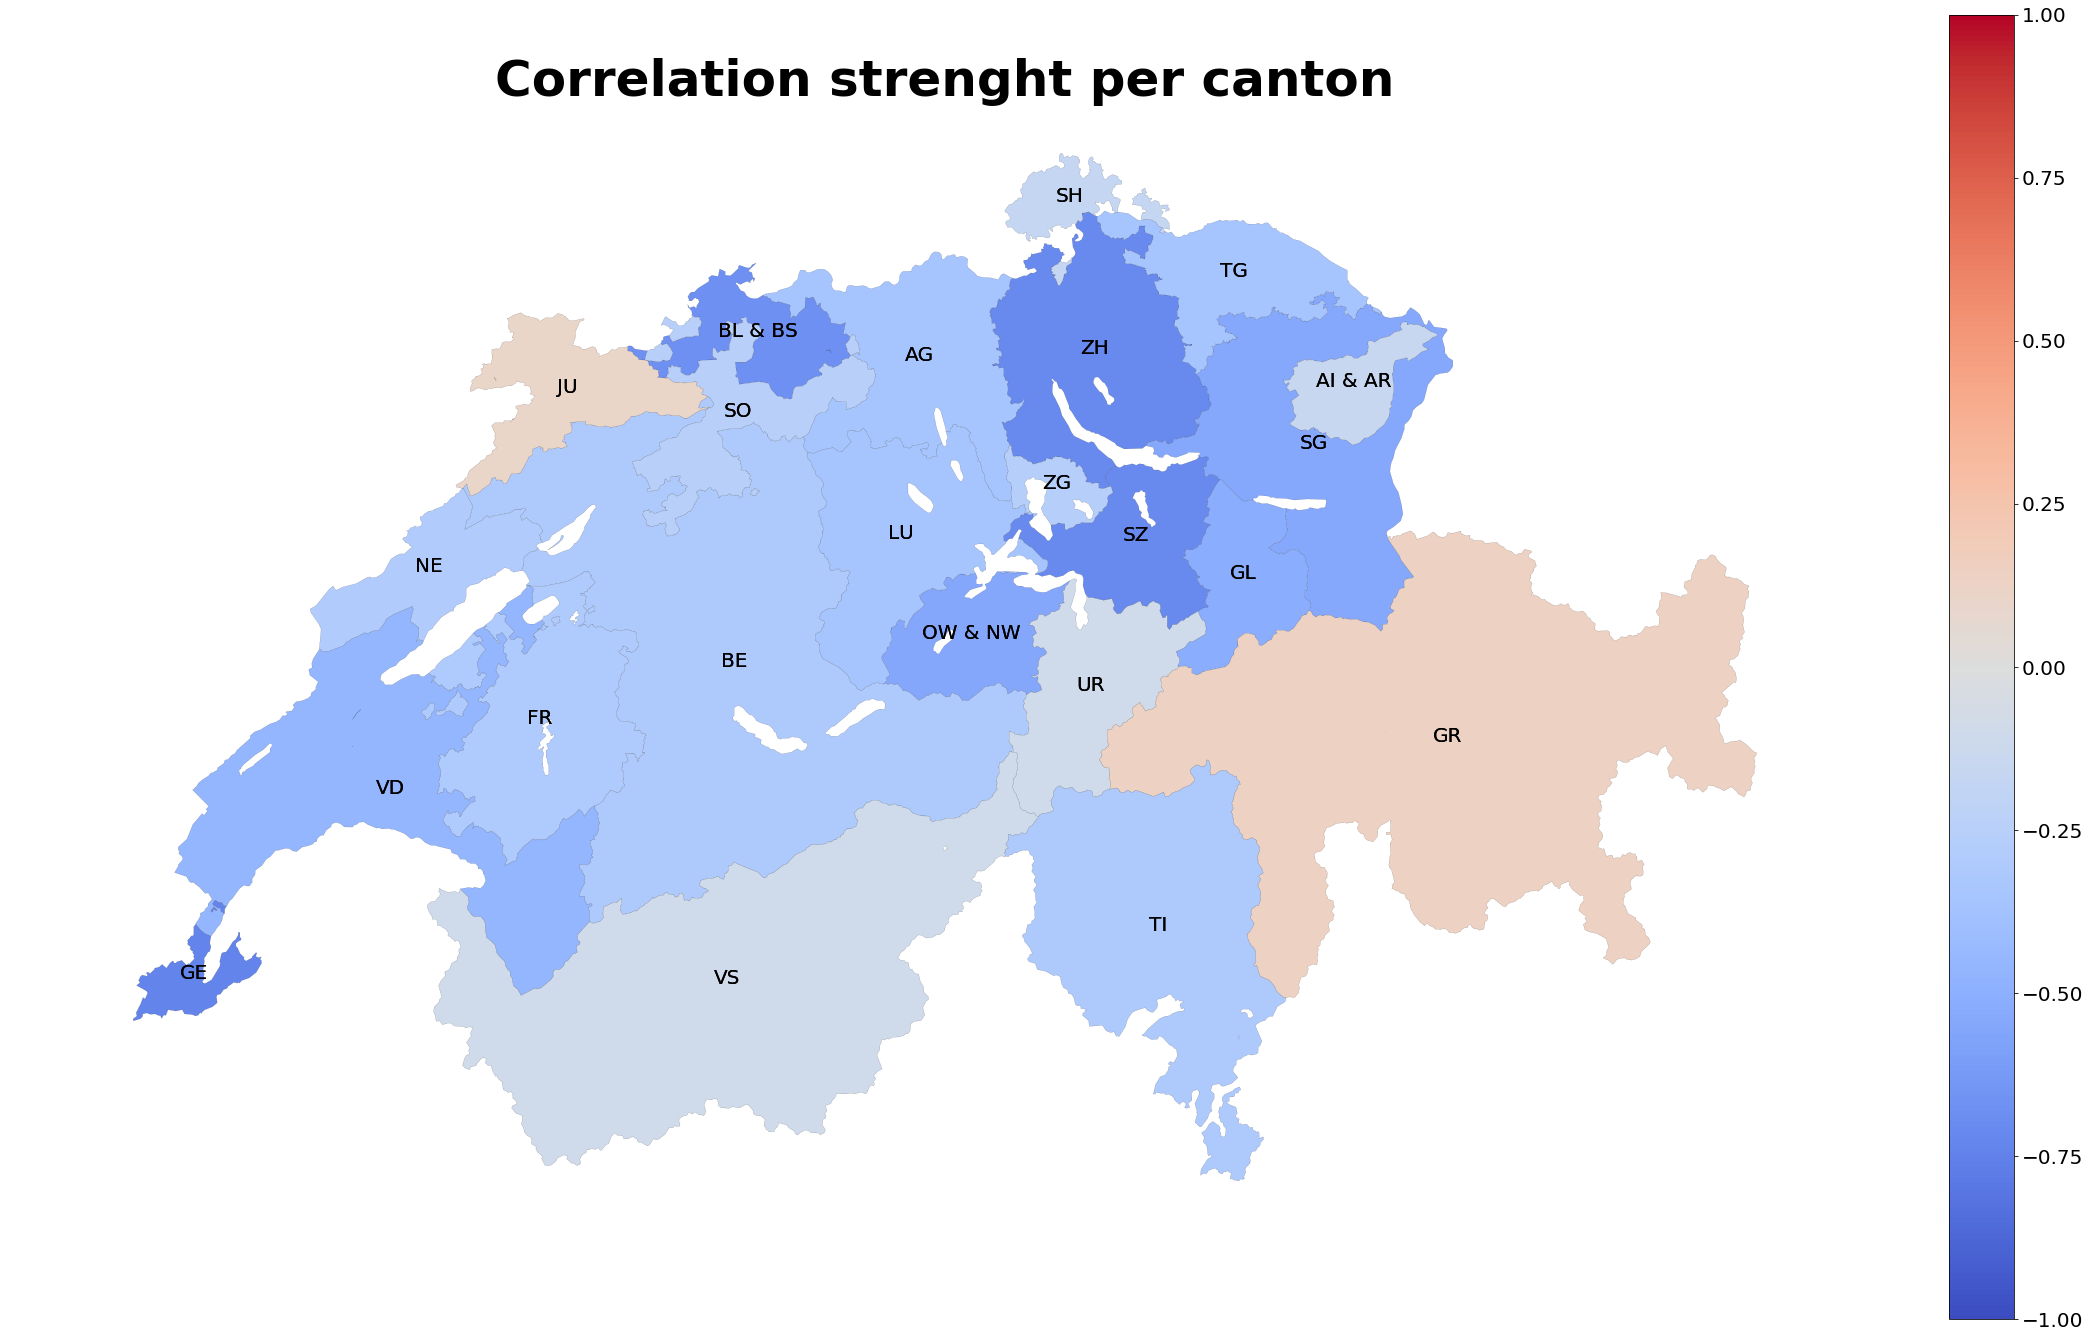

In [98]:
# again the workaround, this will produce a warning i know
newrow1 = gpd.GeoDataFrame({'corr':[1]})   
newrow2 = gpd.GeoDataFrame({'corr':[-1]})
# merge it back to the geodata data frame
plotdata = pd.concat([cantondata, newrow1], sort=True)
plotdata =pd.concat([plotdata,newrow2], sort=True)

variable = 'corr'

vmin, vmax = -1, 1

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(40, 24))
# create map
plotdata.plot(column=variable, cmap="coolwarm",alpha=1, linewidth=0.1, ax=ax, edgecolor='black')

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Correlation strenght per canton', \
              fontdict={'fontsize': '50',
                        'fontweight' : 'bold'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
plotdata.apply(lambda x: ax.annotate(s=x.canton, xy=x.geometry.centroid.coords[0], ha='center',fontsize=20),axis=1)